In [2]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
from dateutil.parser import parse
from matplotlib import ticker
from cartopy import crs, feature
from salishsea_tools import viz_tools
from cmocean import cm
from glob import glob
from tqdm.notebook import tqdm

import NEMO_upwelling_postprocessing as ps

%matplotlib inline

In [53]:
plt.rcParams['font.size'] = 12

In [4]:
path = '/ocean/bmoorema/research/MEOPAR/analysis-ben-hg/data/MODIS'
coords = xr.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)

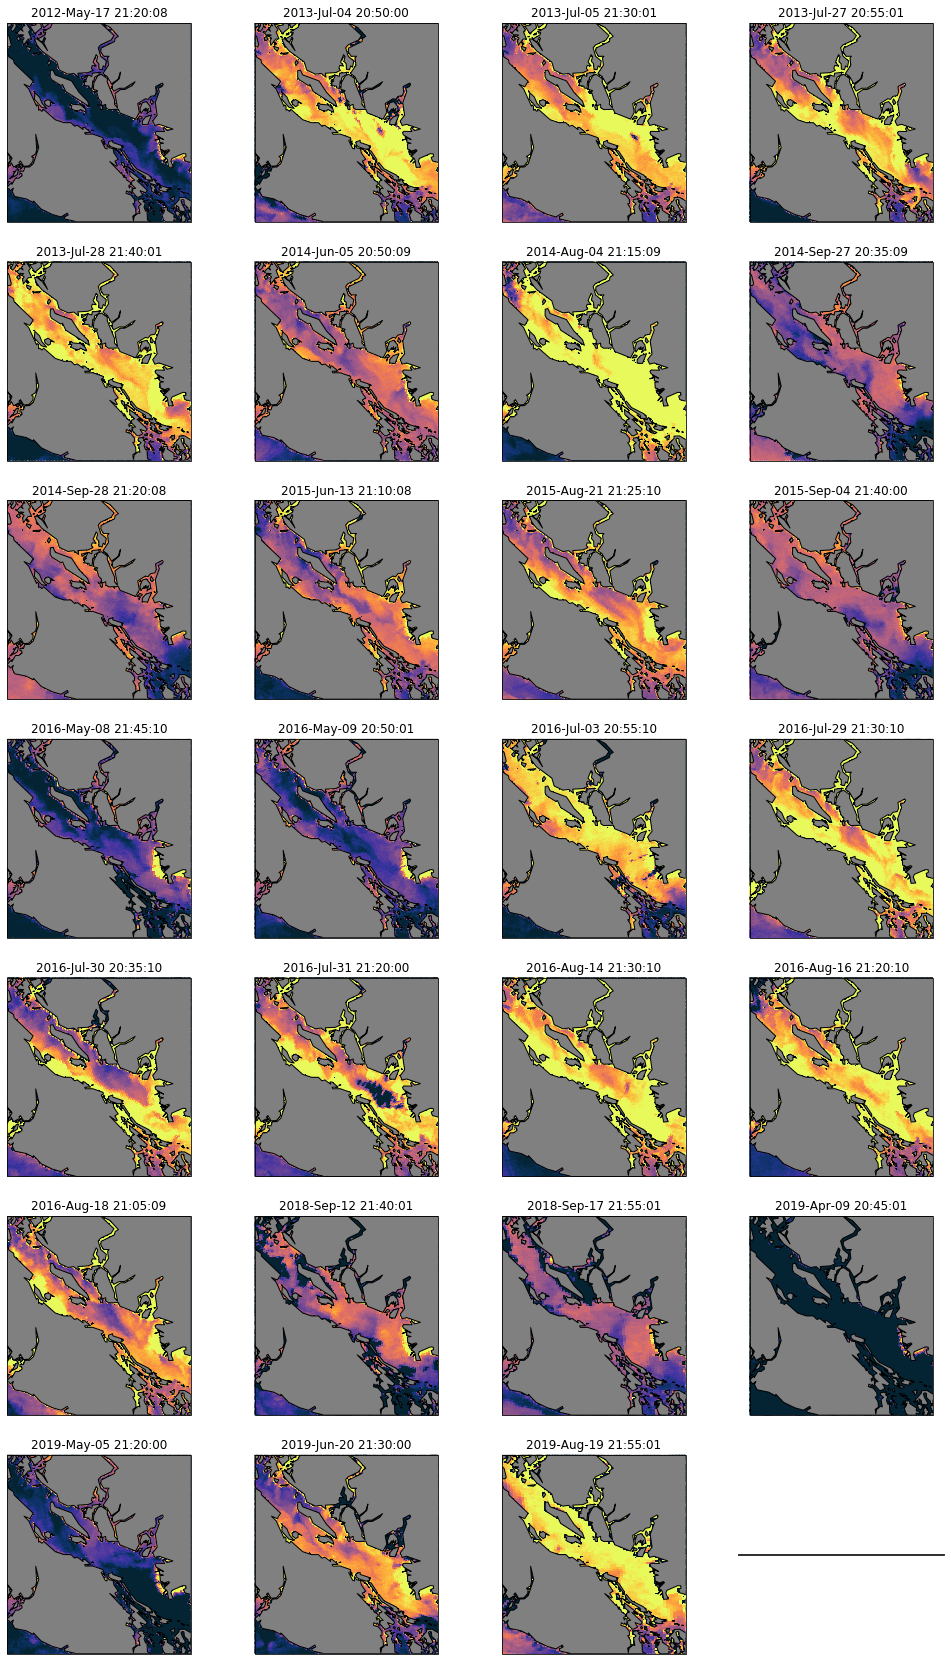

In [235]:
# Plot all SST images
xlim, ylim = [-125.2, -122.8], [48.5, 50.2]
fig, axs = plt.subplots(7, 4, figsize=(17, 30), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
axs = axs.reshape(28)

for ax, file in zip(tqdm(axs[:27]), sorted(glob(path + '/A*'))):
    
    # Parse date from file string
    date = parse(file.split('/')[-1].split('.')[1]).strftime('%Y-%b-%d %H:%M:%S')
    
    # Plot map
    ax.set_extent(xlim + ylim)
    ax.add_feature(feature.GSHHSFeature('i', edgecolor='k', facecolor='gray'))
    ax.set_title(date)
    
    with nc.Dataset(file) as ds: #path + parse(date).strftime('A%Y%j%H%M%S.L2_LAC_SST.nc')) as ds:
        
        # Extract fields
        lon = np.array(ds.groups['navigation_data'].variables['longitude'])
        lat = np.array(ds.groups['navigation_data'].variables['latitude'])
        sst = np.array(ds.groups['geophysical_data'].variables['sst'])

    # Plot data
    c = ax.pcolormesh(lon, lat, sst, vmin=11, vmax=19, cmap=cm.thermal, transform=crs.PlateCarree())

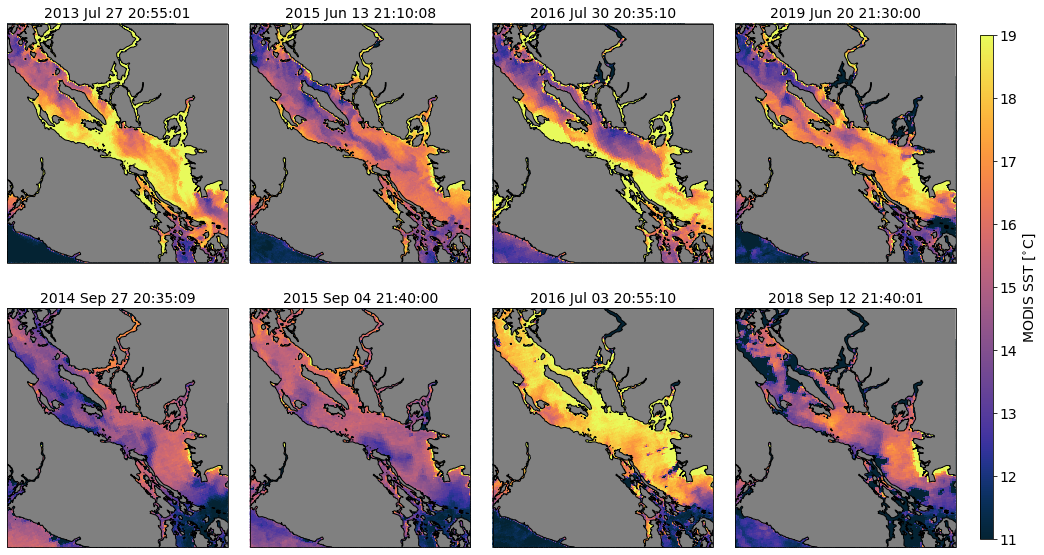

In [4]:
events = [
    {'date': '2013 Jul 27 20:55:01', 'bbox': (slice(1010, 1300), slice( 870, 1030))},
    {'date': '2015 Jun 13 21:10:08', 'bbox': (slice( 170, 400 ), slice( 650,  850))},
    {'date': '2016 Jul 30 20:35:10', 'bbox': (slice(1470, 1750), slice(1100, 1220))},
    {'date': '2019 Jun 20 21:30:00', 'bbox': (slice(1650, 1900), slice( 270,  430))},
    {'date': '2014 Sep 27 20:35:09', 'bbox': (slice(1730, 2000), slice(1100, 1220))},
    {'date': '2015 Sep 04 21:40:00', 'bbox': (slice(  70, 310 ), slice( 200,  350))},
    {'date': '2016 Jul 03 20:55:10', 'bbox': (slice( 850, 1100), slice( 850, 1030))},
    {'date': '2018 Sep 12 21:40:01', 'bbox': (slice( 210, 500) , slice( 200,  350))},
    {'date': '2019 Aug 02 21:15:01', 'bbox': (slice( 200,  450), slice( 530,  700))},
]

xlim, ylim = [-125.2, -122.8], [48.5, 50.2]
subplot_kw = {'projection': crs.Mercator(np.mean(xlim), *ylim)}
gridspec_kw = {'hspace': 0.1, 'wspace': 0.1}
fig, axs = plt.subplots(2, 4, figsize=(17, 10), subplot_kw=subplot_kw, gridspec_kw=gridspec_kw)
axs = axs.reshape(8)

for ax, event in zip(axs, events):
        
    # Parse date from file string
    file = parse(event['date']).strftime('/SST/AQUA_MODIS.%Y%m%dT%H%M%S.L2.SST.nc')

    # Plot map
    ax.set_extent(xlim + ylim)
    ax.add_feature(feature.GSHHSFeature('h', edgecolor='k', facecolor='gray'))
    ax.set_title(event['date'], fontdict={'size': 14})

    data, bounds = {}, {}
    with nc.Dataset(path + file) as ds:

        # Extract fields
        lon = np.array(ds.groups['navigation_data'].variables['longitude'])[event['bbox']]
        lat = np.array(ds.groups['navigation_data'].variables['latitude'])[event['bbox']]
        sst = np.array(ds.groups['geophysical_data'].variables['sst'])[event['bbox']]
    
    # Plot data
    c = ax.pcolormesh(lon, lat, sst, vmin=11, vmax=19, cmap=cm.thermal, transform=crs.PlateCarree(), rasterized=True)

cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label='MODIS SST [$^{\circ}$C]')
#fig.savefig('/home/bmoorema/Desktop/CMOS2020/figs/MODIS_SST.pdf', bbox_inches='tight', dpi=300)

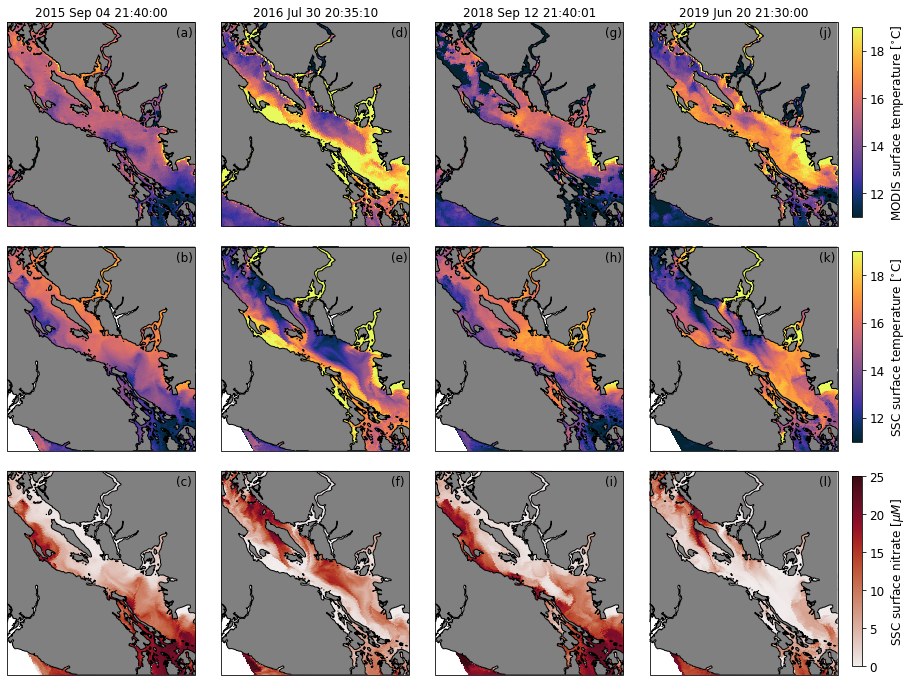

In [61]:
events = [
    {'date': '2015 Sep 04 21:40:00', 'bbox': (slice(  70,  310), slice( 200,  350))},
    {'date': '2016 Jul 30 20:35:10', 'bbox': (slice(1470, 1750), slice(1100, 1220))},
    {'date': '2018 Sep 12 21:40:01', 'bbox': (slice( 210,  500), slice( 200,  350))},
    {'date': '2019 Jun 20 21:30:00', 'bbox': (slice(1650, 1900), slice( 270,  430))},
]
c, data = {}, {'MODIS': {}, 'SalishSeaCast': {'lon': coords.nav_lon.values, 'lat': coords.nav_lat.values}}
xlim, ylim = [-125.2, -122.8], [48.5, 50.2]
subplot_kw = {'projection': crs.Mercator(np.mean(xlim), *ylim)}
gridspec_kw = {'hspace': 0.1, 'wspace': 0.1}
fig, axs = plt.subplots(3, 4, figsize=(15, 12), subplot_kw=subplot_kw, gridspec_kw=gridspec_kw)

n = 0
for col, event in zip(axs.T, events):
    
    # Parse date
    date = parse(event['date'])

    # Load MODIS
    file = date.strftime('/SST/AQUA_MODIS.%Y%m%dT%H%M%S.L2.SST.nc')
    with nc.Dataset(path + file) as ds:
        data['MODIS']['lon'] = np.array(ds.groups['navigation_data'].variables['longitude'])[event['bbox']]
        data['MODIS']['lat'] = np.array(ds.groups['navigation_data'].variables['latitude'])[event['bbox']]
        data['MODIS']['SST'] = np.array(ds.groups['geophysical_data'].variables['sst'])[event['bbox']]
    
    # Load SSC
    prefix = ps.make_prefix(date)
    for key, var, name in zip(['grid', 'ptrc'], ['SST', 'Nitrate'], ['votemper', 'nitrate']):
        with xr.open_dataset(prefix + f'_{key}_T.nc') as ds:
            data['SalishSeaCast'][var] = ds.sel(time_counter=date, method='nearest')[name][0, ...].values
        
    # Plot panel
    for ax, key, var, cmap, bounds in zip(
        col, ['MODIS', 'SalishSeaCast', 'SalishSeaCast'], ['SST', 'SST', 'Nitrate'],
        ['thermal', 'thermal', 'amp'], [(11, 19), (11, 19), (0, 25)]
    ):
        ax.set_extent(xlim + ylim)
        ax.add_feature(feature.GSHHSFeature('h', edgecolor='k', facecolor='gray'))
        c[var] = ax.pcolormesh(
            data[key]['lon'], data[key]['lat'], data[key][var], vmin=bounds[0], vmax=bounds[1],
            cmap=getattr(cm, cmap), transform=crs.PlateCarree(), rasterized=True,
        )
        ax.text(0.9, 0.93, f'({chr(97+n)})', transform=ax.transAxes)
        n += 1
    col[0].set_title(event['date'], fontsize=12)
    
# Colorbar
labels = ['MODIS surface temperature [$^{\circ}$C]', 'SSC surface temperature [$^{\circ}$C]', 'SSC surface nitrate [$\mu M$]']
for var, ypos, label in zip(['SST', 'SST', 'Nitrate'], [0.655, 0.395, 0.135], labels):
    cax = fig.add_axes([0.91, ypos, 0.01, 0.22])
    fig.colorbar(c[var], cax=cax, label=label)
fig.savefig('/home/bmoorema/Desktop/surfacefields.pdf', bbox_inches='tight', dpi=300)